# Exploitation of the data generated by the verifiers

In [5]:
from datasets import load_from_disk,Dataset
import pandas as pd
import seaborn as sb

ds_path =f"notebooks/verifier_execution/datasets/preview/full_ds" 
full_ds = load_from_disk(ds_path)



In [6]:
full_ds

Dataset({
    features: ['id', 'approach_name', 'config_metadata', 'initial_code', 'initial_image', 'initial_instruction', 'initial_solution', 'initial_solution_image', 'expected', 'classified_score', 'failed', 'retries', 'try', 'index', 'errors', 'additional_metadata', 'usage_metadata', 'theoretical_perfect_image'],
    num_rows: 150
})

## TP FP rates with a set threshold

In [7]:
threshold = 0.9
def compute_tpfp(row):
    cl = "unassigned"
    if row["classified_score"]!=None:
        expected = bool(row["expected"])
        classified = float(row["classified_score"])>threshold
        if expected and classified:
            cl = "TP"
        if not expected and classified:
            cl = "FP"
        if expected and not classified:
            cl = "FN"
        if not expected and not classified:
            cl = "TN" 
    row["classification"] = cl
    
    return row

In [8]:

rates_ds = full_ds.map(compute_tpfp)
rates_df = rates_ds.to_pandas()
rates_df = rates_df[["approach_name","classification","id","try","index","classified_score","expected"]]

Map: 100%|██████████| 150/150 [00:00<00:00, 414.86 examples/s]


In [9]:
rates_df

,approach_name,classification,id,try,index,classified_score,expected
0,PicoBananaVerifier,FP,bee_longer_body,0,0,1.000000,False
1,PicoBananaVerifier,TP,bee_longer_body,0,1,1.000000,True
2,PicoBananaVerifier,FP,bee_three_wings,0,0,1.000000,False
3,PicoBananaVerifier,TP,bee_three_wings,0,1,1.000000,True
4,PicoBananaVerifier,FP,bee_three_wings,0,0,1.000000,False
...,...,...,...,...,...,...,...
145,ClipSimVerifier,FP,chimpanzee_open_mouth,0,0,0.972488,False
146,ClipSimVerifier,TP,chimpanzee_open_mouth,0,0,1.000000,True
147,ClipSimVerifier,TN,colnodes_colored,0,0,0.899930,False
148,ClipSimVerifier,TP,colnodes_colored,0,0,1.000000,True


Text(0.5, 0, '')

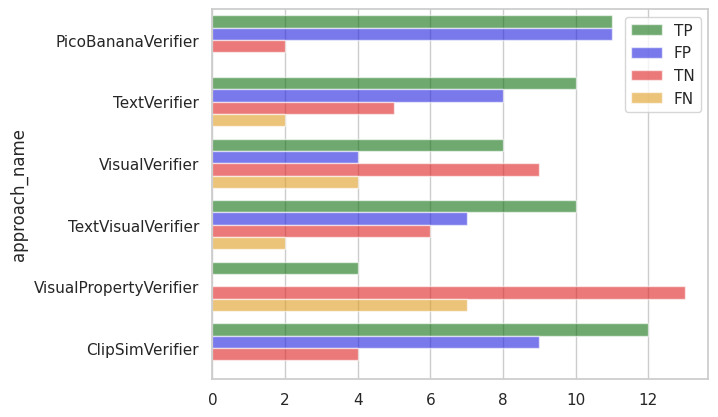

In [10]:
import seaborn as sns
import matplotlib.ticker as ticker

sns.set_theme(style="whitegrid")

g = sns.countplot(
    data=rates_df,
    y="approach_name",
    hue="classification",
    palette=['green', 'blue', 'red','orange'],
    alpha=0.6,
    hue_order=["TP","FP","TN","FN"]
)
#todo change order and color of the labels to make it clearer

g.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
g.legend_.set_title(None)
g.set_xlabel("")


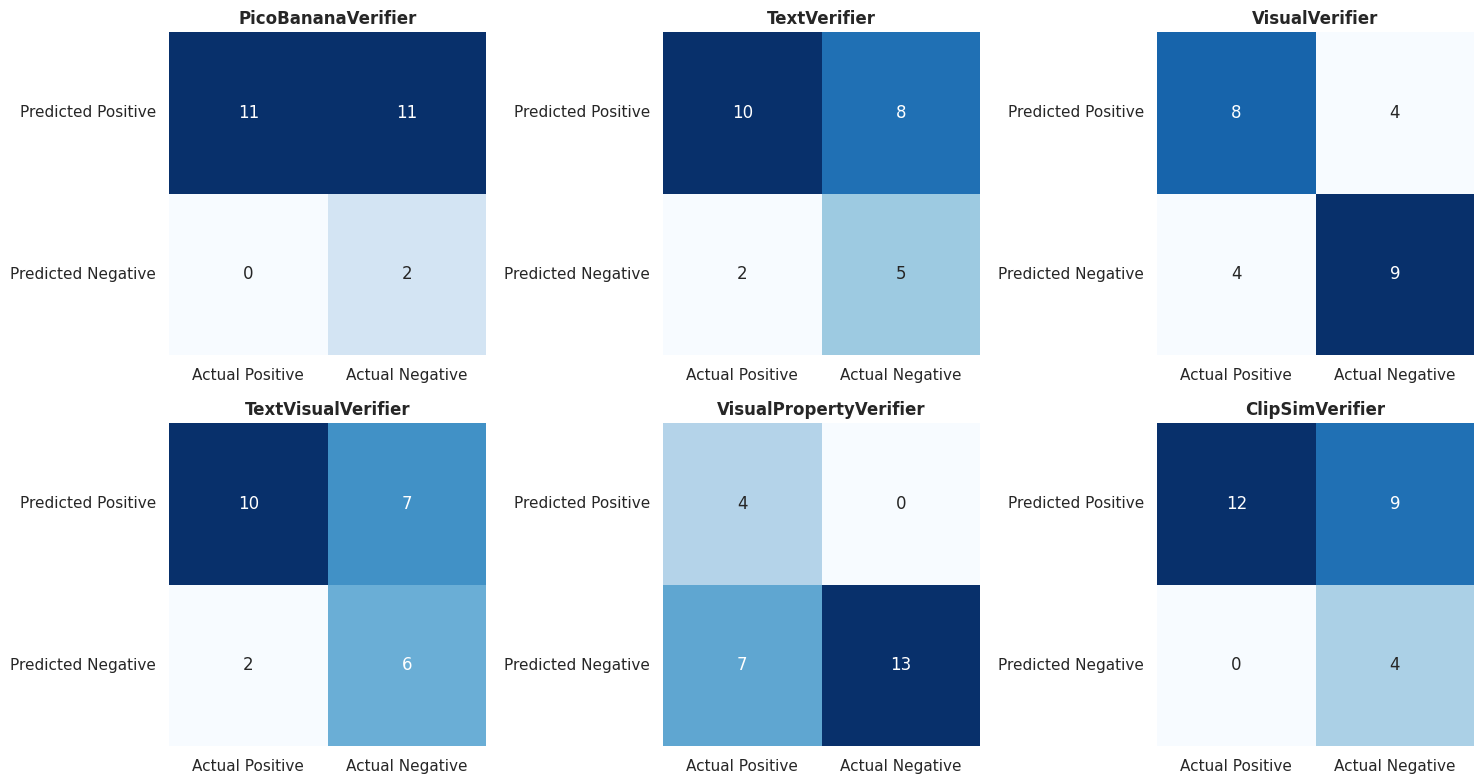

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")

# Get unique approaches
approaches = rates_df['approach_name'].unique()

# Calculate number of rows and columns for subplots
n_approaches = len(approaches)
n_cols = min(3, n_approaches)  # Max 3 columns
n_rows = int(np.ceil(n_approaches / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_approaches == 1:
    axes = np.array([axes])
axes = axes.flatten()

# Create confusion matrix for each approach
for idx, approach in enumerate(approaches):
    # Filter data for this approach
    approach_data = rates_df[rates_df['approach_name'] == approach]
    
    # Count occurrences of each classification
    counts = approach_data['classification'].value_counts()
    
    # Create 2x2 confusion matrix (Predicted vs Actual)
    matrix = np.array([
        [counts.get('TP', 0), counts.get('FP', 0)],
        [counts.get('FN', 0), counts.get('TN', 0)]
    ])
    
    # Plot heatmap
    sns.heatmap(
        matrix,
        annot=True,
        fmt='g',
        cmap='Blues',
        cbar=False,
        ax=axes[idx],
        yticklabels=['Predicted Positive', 'Predicted Negative'],
        xticklabels=['Actual Positive', 'Actual Negative']
    )
    
    axes[idx].set_title(f'{approach}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Hide empty subplots
for idx in range(n_approaches, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Precision and recall

In [12]:
import pandas as pd

def compute_metrics(group):
    TP = (group["classification"] == "TP").sum()
    FP = (group["classification"] == "FP").sum()
    FN = (group["classification"] == "FN").sum()
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return pd.Series({"precision": precision, "recall": recall, "f1": f1})

metrics_df = rates_df.groupby("approach_name").apply(compute_metrics).reset_index()
metrics_df


/tmp/ipykernel_8570/1650661538.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = rates_df.groupby("approach_name").apply(compute_metrics).reset_index()


,approach_name,precision,recall,f1
0,ClipSimVerifier,0.571429,1.000000,0.727273
1,PicoBananaVerifier,0.500000,1.000000,0.666667
2,TextVerifier,0.555556,0.833333,0.666667
3,TextVisualVerifier,0.588235,0.833333,0.689655
4,VisualPropertyVerifier,1.000000,0.363636,0.533333
5,VisualVerifier,0.666667,0.666667,0.666667


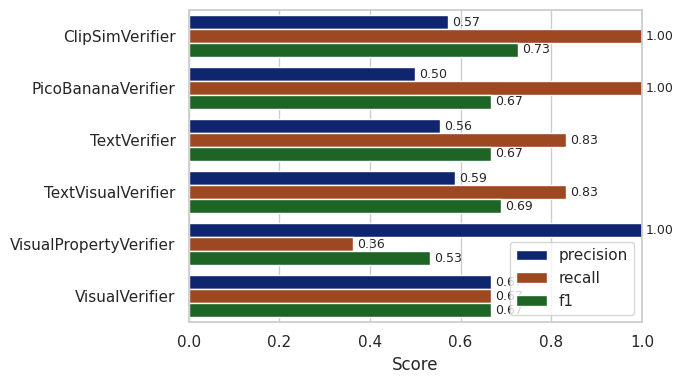

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics_melted = metrics_df.melt(id_vars="approach_name", var_name="metric", value_name="score")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 4))

g = sns.barplot(
    data=metrics_melted,
    y="approach_name",
    x="score",
    hue="metric",
    palette="dark",
    orient="h"
)

# Add value labels
for container in g.containers:
    g.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=9)

g.set_ylabel("")
g.set_xlabel("Score")
g.legend_.set_title("")
g.set_xlim(0, 1)

plt.tight_layout()
plt.show()


## Roc Curves

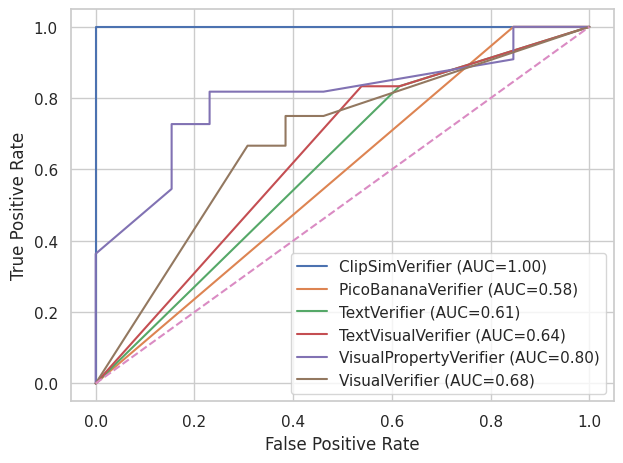

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_ds = full_ds.to_pandas()[["approach_name", "classified_score", "expected"]]
roc_ds = roc_ds.dropna()
plt.figure()

for name, sub in roc_ds.groupby("approach_name"):
    y_true = sub["expected"]
    y_score = sub["classified_score"]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


## Token usage

In [17]:
set(full_ds["approach_name"])

{'ClipSimVerifier',
 'PicoBananaVerifier',
 'TextVerifier',
 'TextVisualVerifier',
 'VisualPropertyVerifier',
 'VisualVerifier'}

In [26]:
import json


def none_row(row):
    row["input_tokens"] = None
    row["output_tokens"] = None
    row["total_tokens"] = None
    return row


def compute_usage(row):
    usage_loaded = json.loads(row["usage_metadata"])
    match row["approach_name"]:
        case (
            "TextVerifier"
            | "VisualVerifier"
            | "TextVisualVerifier"
            | "PicoBananaVerifier"
        ):
            if "Base" not in usage_loaded or usage_loaded["Base"] == None:
                return none_row(row)
            base_usage = usage_loaded["Base"][0]
            row["input_tokens"] = base_usage["prompt_tokens"]
            row["output_tokens"] = base_usage["completion_tokens"]
            row["total_tokens"] = base_usage["total_tokens"]
        case "VisualPropertyVerifier":
            if (
                "property_gen" not in usage_loaded
                or "property_check" not in usage_loaded
                or usage_loaded["property_gen"] == None
                or usage_loaded["property_check"] == None
            ):
                return none_row(row)
            propgen_usage = usage_loaded["property_gen"][0]
            propcheck_usage = usage_loaded["property_check"]
            row["input_tokens"] = propgen_usage["prompt_tokens"] + sum(
                [tok_u["prompt_tokens"] for tok_u in propcheck_usage]
            )
            row["output_tokens"] = propgen_usage["completion_tokens"] + sum(
                [tok_u["completion_tokens"] for tok_u in propcheck_usage]
            )
            row["total_tokens"] = propgen_usage["total_tokens"] + sum(
                [tok_u["total_tokens"] for tok_u in propcheck_usage]
            )
        case "ClipSimVerifier":
            row["input_tokens"] = 0
            row["output_tokens"] = 0
            row["total_tokens"] = 0
    return row

In [27]:

token_ds = full_ds.map(compute_usage)

Map: 100%|██████████| 150/150 [00:00<00:00, 394.36 examples/s]


In [28]:
token_df = token_ds.to_pandas()
token_df = token_df[["approach_name","id","total_tokens","output_tokens","input_tokens"]]

<Axes: ylabel='approach_name'>

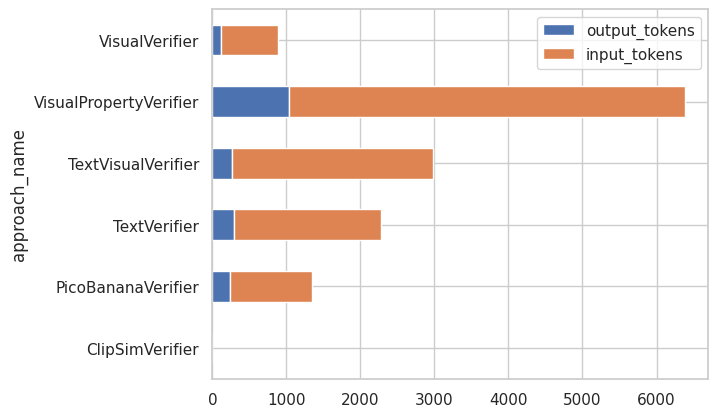

In [29]:
avg_token_df = token_df[["approach_name","output_tokens","input_tokens"]].groupby("approach_name").mean().reset_index()
avg_token_df = avg_token_df.set_index("approach_name")
avg_token_df.plot(kind='barh',stacked=True)


## Error classifications

In [ ]:
roc_ds = full_ds.to_pandas()[["approach_name", "classified_score", "expected"]]


In [ ]:
err_df = full_ds.to_pandas()
